# Handling distractor interference in mixed and fixed search 
### A. A. Hanne, J. Tünnermann & A. Schubö

Fitting Bayesian Generalized Linear Mixed Models using the Python package Bambi.
Citation: Capretto, T., Piho, C., Kumar, R., Westfall, J., Yarkoni, T., & Martin, O. A. (2022). Bambi: A Simple Interface for Fitting Bayesian Linear Models in Python. Journal of Statistical Software, 103(15). https://doi.org/10.18637/jss.v103.i15

GitHub: https://bambinos.github.io/bambi/

The analyses were performed with a Bambi version installed from 
https://github.com/GStechschulte/bambi.git@8fa47aa, Python version 3.9.18 and PyMC version 5.8.2.

Due to the stochastic nature of MCMC sampling, the results depicted in this notebook might differ slightly numerically from the values reported in the paper.

This notebook can sample the traces or you can load them from disk (see README.md) and copy them in a traces/ subfolder.

## Time Course of Distractor Location Learning

### 1) Define and run model

In [17]:
import arviz as az
import pandas as pd
import bambi as bmb
import cloudpickle
import warnings
warnings.filterwarnings("ignore")
from os import path

seed=12345
tune = 5000
draws = 20000
name = 'TimeCourseDLL_trace'

fn = 'traces/%s.nc'%name

# Avoid that the user sampels a trace which cannot be stored due to existing file:
if path.exists(fn):
    raise Exception("%s already exisits. Rename new trace above or rename/delete old trace"%fn)

data = pd.read_csv('data/Dataset_TimeCourseDLL.csv', sep=';', decimal='.')


model = bmb.Model(
    '''difference ~ 
       task*session*condition*epoch + (1|participant)
    ''',
    data, family='gaussian', categorical = ["session", "condition", "participant"])

display(model)
model.build()

idata = az.InferenceData()

print('Sampling default prior predictive')
pp = model.prior_predictive(3000)
idata.add_groups({'default_prior': pp.prior, 'default_prior_predictive': pp.prior_predictive})

print('Sampling custom prior predictive')
idata.extend(model.prior_predictive(3000))

print('Sampling posterior')
idata.extend(
    model.fit(tune=tune, draws=draws, random_seed=seed, init='adapt_diag', target_accept=0.99, idata_kwargs={'log_likelihood':True})
)

print('Saving trace to ' + fn)
idata.to_netcdf(fn)

Exception: traces/TimeCourseDLL_trace.nc already exisits. Rename new trace above or rename/delete old trace

### 2) Plot prior predictive distributions

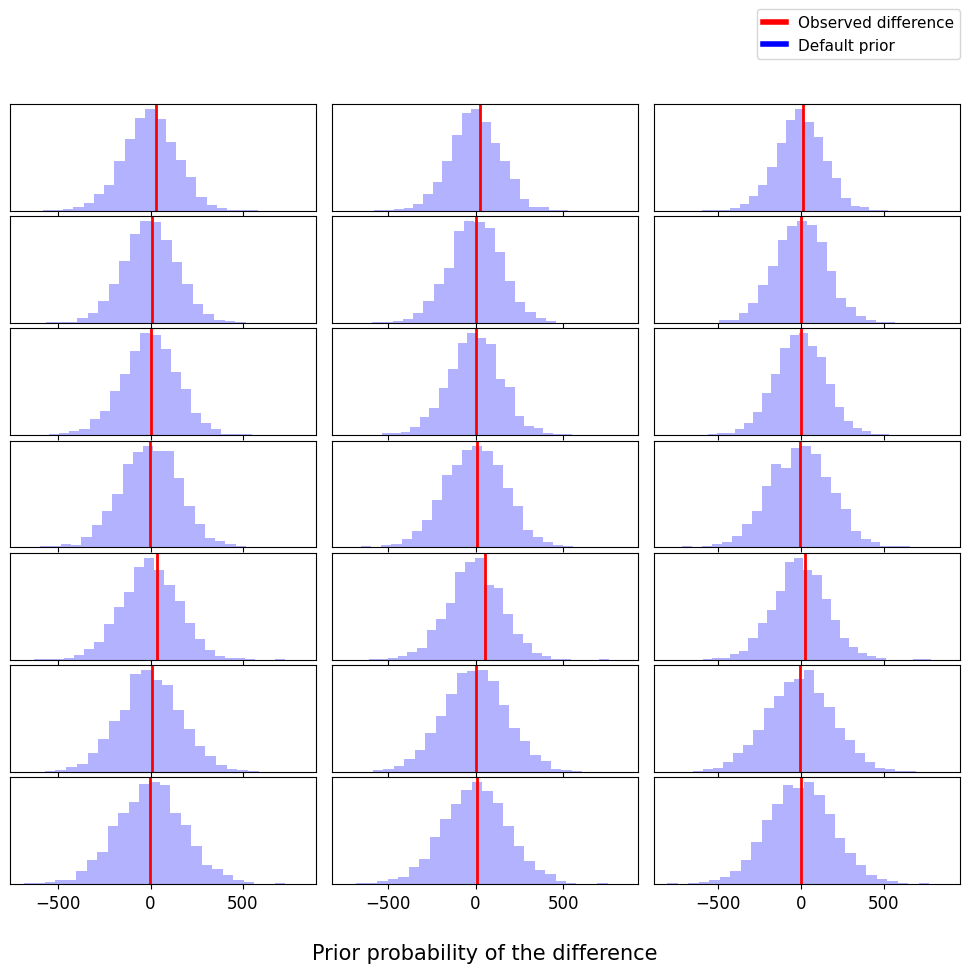

In [18]:
import arviz as az 
from plots import plot_prior_predictive
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('data/Dataset_TimeCourseDLL.csv', sep=';', decimal=',') 
idata = az.from_netcdf('traces/TimeCourseDLL_trace.nc')                                   
default_prior = az.extract_dataset(idata, group='default_prior_predictive')['difference']
custom_prior = az.extract_dataset(idata, group='prior_predictive')['difference']

axs = plot_prior_predictive(data, default_prior)

### 3) Traceplots

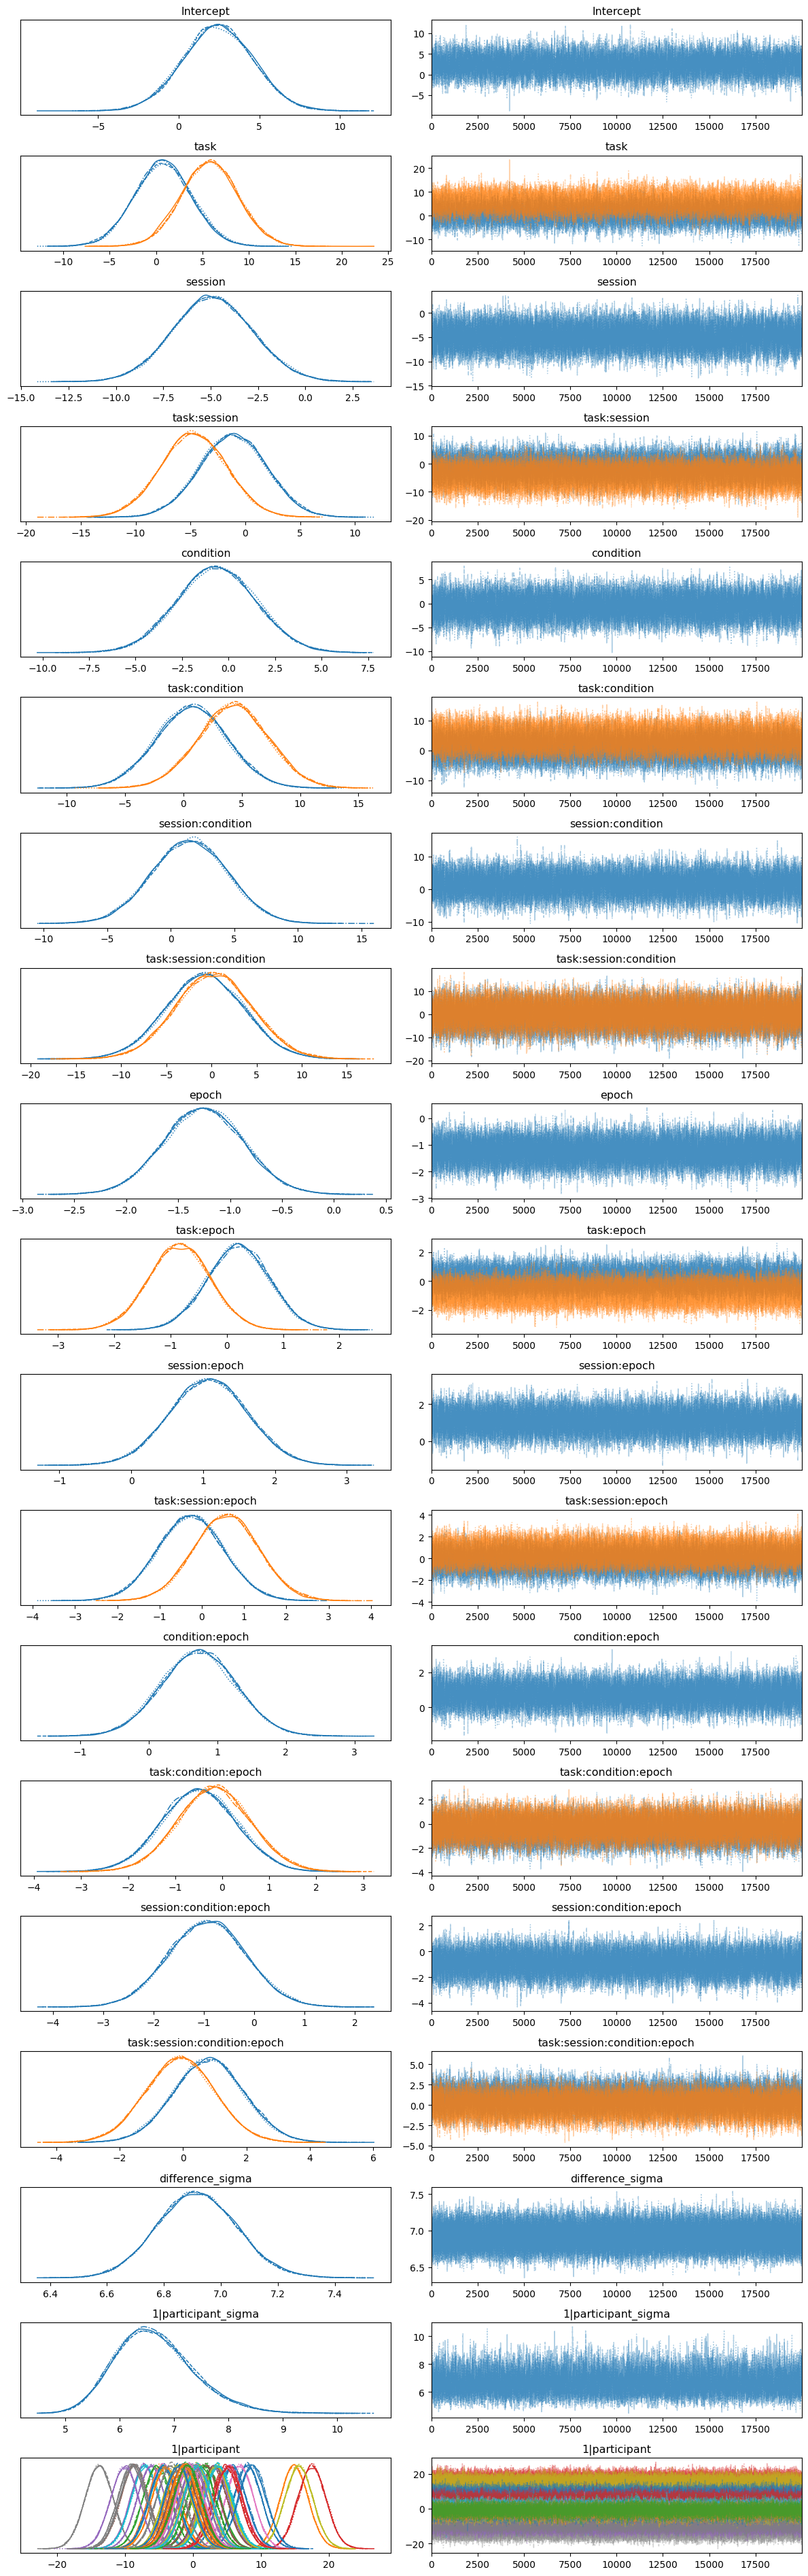

In [3]:
import arviz as az
from matplotlib.pylab import plt
import warnings
warnings.filterwarnings("ignore")

idata = az.from_netcdf('traces/TimeCourseDLL_trace.nc') 
az.plot_trace(idata, compact=True)
plt.tight_layout()

### 4) Get summary

In [4]:
import arviz as az
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
az.rcParams['stats.hdi_prob'] = 0.95

pd.set_option('display.max_rows', None)
idata = az.from_netcdf('traces/TimeCourseDLL_trace.nc') 
az.summary(idata)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.419,2.182,-1.891,6.657,0.027,0.019,6298.0,13384.0,1.0
task[gray],0.752,3.097,-5.248,6.857,0.037,0.026,6984.0,15840.0,1.0
task[mixed],5.800,3.065,-0.276,11.738,0.038,0.027,6612.0,14327.0,1.0
session[2],-4.889,2.118,-8.974,-0.648,0.022,0.016,9165.0,20598.0,1.0
"task:session[gray, 2]",-1.125,3.047,-7.188,4.732,0.030,0.021,10046.0,23250.0,1.0
"task:session[mixed, 2]",-4.720,3.002,-10.571,1.199,0.029,0.021,10480.0,23664.0,1.0
condition[low],-0.651,2.131,-4.745,3.591,0.023,0.016,8529.0,20265.0,1.0
"task:condition[gray, low]",0.696,3.070,-5.460,6.563,0.032,0.022,9475.0,22613.0,1.0
"task:condition[mixed, low]",4.249,3.017,-1.782,10.060,0.031,0.022,9577.0,22525.0,1.0
"session:condition[2, low]",1.489,2.994,-4.425,7.245,0.033,0.023,8465.0,19177.0,1.0


### 5) Compute predictions and comparisons

#### 5.1) Estimates across epochs

In [7]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import bambi as bmb
from bambi.interpret.helpers import data_grid, select_draws
import warnings
bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

data = pd.read_csv('data/Dataset_TimeCourseDLL.csv', sep=';', decimal='.')

idata = az.from_netcdf('traces/TimeCourseDLL_trace.nc')

model = bmb.Model(
    '''difference ~ 
       task*session*condition*epoch + (1|participant)
    ''',
    data, family='gaussian', categorical = ["session", "condition", "participant"])


# Create data_grid
tasks = ["color", "gray", "mixed"]
sessions = [1, 2]
conditions = ["high", "low"]
participants_mixed = np.arange(1, 19)
participants_gray = np.arange(19, 36)
participants_color = np.arange(36, 54 )

variables = {"epoch": np.arange(1, 7)}

data_dict = {}
idata_dict = {}

for task in tasks:
    if task == "mixed":
        participants = participants_mixed
    elif task == "gray":
        participants = participants_gray
    else:
        participants = participants_color

    conditional = {"participant": participants, "condition": conditions, "session": sessions, "task": np.array([task])}
    key = f"{task}_data"
    data_dict[key] = data_grid(model, conditional, variables)
    idata_dict[key] = model.predict(idata, data=data_dict[key], inplace=False)


results_list = []
comparisons_list = []
between_comparisons_list = []
hdi_S1_high_list = []
hdi_S2_high_list = []
hdi_S1_low_list = []
hdi_S2_low_list = []
hdi_diff_1_list = []
hdi_diff_2_list = []


def calculate_stats(idata_dict, data_dict, task):
    key = f"{task}_data" 
    
    # session 1
    draws_session1_1_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 1}, "difference_mean")
    draws_session1_2_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 2}, "difference_mean")
    draws_session1_3_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 3}, "difference_mean")
    draws_session1_4_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 4}, "difference_mean")
    draws_session1_5_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 5}, "difference_mean")
    draws_session1_6_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 6}, "difference_mean")
    
    draws_session1_1_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 1}, "difference_mean")
    draws_session1_2_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 2}, "difference_mean")
    draws_session1_3_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 3}, "difference_mean")
    draws_session1_4_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 4}, "difference_mean")
    draws_session1_5_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 5}, "difference_mean")
    draws_session1_6_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 6}, "difference_mean")

    # session 2
    draws_session2_1_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 1}, "difference_mean")
    draws_session2_2_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 2}, "difference_mean")
    draws_session2_3_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 3}, "difference_mean")
    draws_session2_4_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 4}, "difference_mean")
    draws_session2_5_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 5}, "difference_mean")
    draws_session2_6_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 6}, "difference_mean")

    draws_session2_1_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 1}, "difference_mean")
    draws_session2_2_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 2}, "difference_mean")
    draws_session2_3_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 3}, "difference_mean")
    draws_session2_4_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 4}, "difference_mean")
    draws_session2_5_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 5}, "difference_mean")
    draws_session2_6_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 6}, "difference_mean")        

 
    mean_session1 =xr.concat([xr.concat([draws_session1_1_high,
               draws_session1_2_high,
               draws_session1_3_high,
               draws_session1_4_high,
               draws_session1_5_high,
               draws_session1_6_high],
              'Epoche')\
        .mean(dim='Epoche'),
        xr.concat([draws_session1_1_low,
               draws_session1_2_low,
               draws_session1_3_low,
               draws_session1_4_low,
               draws_session1_5_low,
               draws_session1_6_low],
              'Epoche')\
        .mean(dim='Epoche')],
        dim='Condition'
    ).rename('Estimates')
    
    mean_session2 =xr.concat([xr.concat([draws_session2_1_high,
               draws_session2_2_high,
               draws_session2_3_high,
               draws_session2_4_high,
               draws_session2_5_high,
               draws_session2_6_high],
              'Epoche')\
        .mean(dim='Epoche'),
        xr.concat([draws_session2_1_low,
               draws_session2_2_low,
               draws_session2_3_low,
               draws_session2_4_low,
               draws_session2_5_low,
               draws_session2_6_low],
              'Epoche')\
        .mean(dim='Epoche')],
        dim='Condition'
    ).rename('Estimates')

    
    # high
    mean_high_session1 = mean_session1.sel(Condition=0).mean(dim='difference_obs').values
    results_list.append({"session": 1, "condition": "high", "task": task, "estimate": np.mean(mean_high_session1)})
    hdi_S1_high = az.hdi(mean_session1.sel(Condition=0).mean(dim='difference_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_S1_high_df = hdi_S1_high.to_dataframe(dim_order=None)
    hdi_S1_high_list.append(hdi_S1_high_df)
    
    mean_high_session2 = mean_session2.sel(Condition=0).mean(dim='difference_obs').values
    results_list.append({"session": 2, "condition": "high", "task": task, "estimate": np.mean(mean_high_session2)})
    hdi_S2_high = az.hdi(mean_session2.sel(Condition=0).mean(dim='difference_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_S2_high_df = hdi_S2_high.to_dataframe(dim_order=None)
    hdi_S2_high_list.append(hdi_S2_high_df)
        
    # low
    mean_low_session1 = mean_session1.sel(Condition=1).mean(dim='difference_obs').values
    results_list.append({"session": 1, "condition": "low", "task": task, "estimate": np.mean(mean_low_session1)})
    hdi_S1_low = az.hdi(mean_session1.sel(Condition=1).mean(dim='difference_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_S1_low_df = hdi_S1_low.to_dataframe(dim_order=None)
    hdi_S1_low_list.append(hdi_S1_low_df)
    

    mean_low_session2 = mean_session2.sel(Condition=1).mean(dim='difference_obs').values
    results_list.append({"session": 2, "condition": "low", "task": task, "estimate": np.mean(mean_low_session2)})
    hdi_S2_low = az.hdi(mean_session2.sel(Condition=1).mean(dim='difference_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_S2_low_df = hdi_S2_low.to_dataframe(dim_order=None)
    hdi_S2_low_list.append(hdi_S2_low_df)

        
    # Difference between high and low
    mean_diff_1 = (mean_session1.sel(Condition=0) - mean_session1.sel(Condition=1)).mean(dim='difference_obs').values
    comparisons_list.append({"session": 1, "condition": "Δ (high, low)", "task": task, "estimate": np.mean(mean_diff_1)})
    hdi_diff_1 = az.hdi((mean_session1.sel(Condition=0) - mean_session1.sel(Condition=1)).mean(dim='difference_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_diff_df_1 = hdi_diff_1.to_dataframe(dim_order=None)
    hdi_diff_1_list.append(hdi_diff_df_1)
    
    mean_diff_2 = (mean_session2.sel(Condition=0) - mean_session2.sel(Condition=1)).mean(dim='difference_obs').values
    comparisons_list.append({"session": 2, "condition": "Δ (high, low)", "task": task, "estimate": np.mean(mean_diff_2)})  
    hdi_diff_2 = az.hdi((mean_session2.sel(Condition=0) - mean_session2.sel(Condition=1)).mean(dim='difference_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_diff_df_2 = hdi_diff_2.to_dataframe(dim_order=None)
    hdi_diff_2_list.append(hdi_diff_df_2)
    
    
for task in tasks:
    calculate_stats(idata_dict, data_dict, task)

mean_df = pd.DataFrame(results_list)
within_comparisons_df = pd.DataFrame(comparisons_list)


Session1_high_indices = mean_df[(mean_df['session'] == 1) & (mean_df['condition'] == "high")].index
Session2_high_indices = mean_df[(mean_df['session'] == 2) & (mean_df['condition'] == "high")].index

Session1_low_indices = mean_df[(mean_df['session'] == 1) & (mean_df['condition'] == "low")].index
Session2_low_indices = mean_df[(mean_df['session'] == 2) & (mean_df['condition'] == "low")].index

Session1_diff_indices = within_comparisons_df[within_comparisons_df['session'] == 1].index
Session2_diff_indices = within_comparisons_df[within_comparisons_df['session'] == 2].index


def extract_hdi_values(hdi_df):
    lower_value = hdi_df.loc['lower', 'Estimates']
    higher_value = hdi_df.loc['higher', 'Estimates']
    return lower_value, higher_value

for S1_index_high, hdi_df in zip(Session1_high_indices, hdi_S1_high_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    mean_df.at[S1_index_high, 'lower_2.5%'] = lower_col
    mean_df.at[S1_index_high, 'upper_97.5%'] = higher_col

for S2_index_high, hdi_df in zip(Session2_high_indices, hdi_S2_high_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    mean_df.at[S2_index_high, 'lower_2.5%'] = lower_col
    mean_df.at[S2_index_high, 'upper_97.5%'] = higher_col

for S1_index_low, hdi_df in zip(Session1_low_indices, hdi_S1_low_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    mean_df.at[S1_index_low, 'lower_2.5%'] = lower_col
    mean_df.at[S1_index_low, 'upper_97.5%'] = higher_col

for S2_index_low, hdi_df in zip(Session2_low_indices, hdi_S2_low_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    mean_df.at[S2_index_low, 'lower_2.5%'] = lower_col
    mean_df.at[S2_index_low, 'upper_97.5%'] = higher_col
    
for S1_index_diff, hdi_df in zip(Session1_diff_indices, hdi_diff_1_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    within_comparisons_df.at[S1_index_diff, 'lower_2.5%'] = lower_col
    within_comparisons_df.at[S1_index_diff, 'upper_97.5%'] = higher_col

for S2_index_diff, hdi_df in zip(Session2_diff_indices, hdi_diff_2_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    within_comparisons_df.at[S2_index_diff, 'lower_2.5%'] = lower_col
    within_comparisons_df.at[S2_index_diff, 'upper_97.5%'] = higher_col
    
mean_df = mean_df.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})
within_comparisons_df = within_comparisons_df.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})
        
display(mean_df)
display(within_comparisons_df)

,session,condition,task,estimate,lower_2.5%,upper_97.5%
0,1,high,color,-2.00,-3.29,-0.70
1,2,high,color,-3.13,-4.43,-1.82
2,1,low,color,-0.11,-1.40,1.20
3,2,low,color,-3.01,-4.28,-1.69
4,1,high,gray,-0.51,-1.87,0.81
5,2,high,gray,-3.68,-4.98,-2.29
6,1,low,gray,0.34,-0.98,1.69
7,2,low,gray,-2.50,-3.85,-1.16
8,1,high,mixed,0.87,-0.44,2.17
9,2,high,mixed,-2.95,-4.27,-1.66


,session,condition,task,estimate,lower_2.5%,upper_97.5%
0,1,"Δ (high, low)",color,-1.89,-3.71,-0.05
1,2,"Δ (high, low)",color,-0.12,-1.97,1.69
2,1,"Δ (high, low)",gray,-0.84,-2.74,1.04
3,2,"Δ (high, low)",gray,-1.19,-3.13,0.68
4,1,"Δ (high, low)",mixed,-5.55,-7.46,-3.75
5,2,"Δ (high, low)",mixed,-3.74,-5.59,-1.90


#### 5.2) Differences between sessions; across epochs and conditions

In [8]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import bambi as bmb
from bambi.interpret.helpers import data_grid, select_draws
import warnings
bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

data = pd.read_csv('data/Dataset_TimeCourseDLL.csv', sep=';', decimal='.')

idata = az.from_netcdf('traces/TimeCourseDLL_trace.nc')

model = bmb.Model(
    '''difference ~ 
       task*session*condition*epoch + (1|participant)
    ''',
    data, family='gaussian', categorical = ["session", "condition", "participant"])


# Create data_grid
tasks = ["color", "gray", "mixed"]
sessions = [1, 2]
conditions = ["high", "low"]
participants_mixed = np.arange(1, 19)
participants_gray = np.arange(19, 36)
participants_color = np.arange(36, 54 )

variables = {"epoch": np.arange(1, 7)}

data_dict = {}
idata_dict = {}

for task in tasks:
    if task == "mixed":
        participants = participants_mixed
    elif task == "gray":
        participants = participants_gray
    else:
        participants = participants_color

    conditional = {"participant": participants, "condition": conditions, "session": sessions, "task": np.array([task])}
    key = f"{task}_data"
    data_dict[key] = data_grid(model, conditional, variables)
    idata_dict[key] = model.predict(idata, data=data_dict[key], inplace=False)


comparisons_list = []
hdi_diff_list = []


def calculate_stats(idata_dict, data_dict, task):
    key = f"{task}_data" 
    draws_session1_1 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 1}, "difference_mean")
    draws_session1_2 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 2}, "difference_mean")
    draws_session1_3 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 3}, "difference_mean")
    draws_session1_4 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 4}, "difference_mean")
    draws_session1_5 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 5}, "difference_mean")
    draws_session1_6 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 6}, "difference_mean")
    
    draws_session2_1 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 1}, "difference_mean")
    draws_session2_2 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 2}, "difference_mean")
    draws_session2_3 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 3}, "difference_mean")
    draws_session2_4 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 4}, "difference_mean")
    draws_session2_5 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 5}, "difference_mean")
    draws_session2_6 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 6}, "difference_mean")        


    # difference between high and low within sessions   
    mean_sessions =xr.concat([xr.concat([draws_session1_1,
               draws_session1_2,
               draws_session1_3,
               draws_session1_4,
               draws_session1_5,
               draws_session1_6],
              'Epoche')\
        .mean(dim='Epoche'),
        xr.concat([draws_session2_1,
               draws_session2_2,
               draws_session2_3,
               draws_session2_4,
               draws_session2_5,
               draws_session2_6],
              'Epoche')\
        .mean(dim='Epoche')],
        dim='Condition'
    ).rename('Estimates')
    

    mean_diff = (mean_sessions.sel(Condition=0) - mean_sessions.sel(Condition=1)).mean(dim='difference_obs').values
    comparisons_list.append({"session": "Δ 1,2", "task": task, "estimate": np.mean(mean_diff)})
    hdi_diff = az.hdi((mean_sessions.sel(Condition=0) - mean_sessions.sel(Condition=1)).mean(dim='difference_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_diff_df = hdi_diff.to_dataframe(dim_order=None)
    hdi_diff_list.append(hdi_diff_df)


for task in tasks:
    calculate_stats(idata_dict, data_dict, task)

within_comparisons_df = pd.DataFrame(comparisons_list)

Session_diff_indices = within_comparisons_df.index

def extract_hdi_values(hdi_df):
    lower_value = hdi_df.loc['lower', 'Estimates']
    higher_value = hdi_df.loc['higher', 'Estimates']
    return lower_value, higher_value

for S1_index_diff, hdi_df in zip(Session_diff_indices, hdi_diff_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    within_comparisons_df.at[S1_index_diff, 'lower_2.5%'] = lower_col
    within_comparisons_df.at[S1_index_diff, 'upper_97.5%'] = higher_col

within_comparisons_df = within_comparisons_df.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})
display(within_comparisons_df)

,session,task,estimate,lower_2.5%,upper_97.5%
0,"Δ 1,2",color,2.02,0.70,3.30
1,"Δ 1,2",gray,3.00,1.66,4.33
2,"Δ 1,2",mixed,4.73,3.43,6.04


#### 5.3) Estimates

In [6]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import bambi as bmb
from bambi.interpret.helpers import data_grid, select_draws
import warnings
bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

data = pd.read_csv('data/Dataset_TimeCourseDLL.csv', sep=';', decimal='.')

idata = az.from_netcdf('traces/TimeCourseDLL_trace.nc')

model = bmb.Model(
    '''difference ~ 
       task*session*condition*epoch + (1|participant)
    ''',
    data, family='gaussian', categorical = ["session", "condition", "participant"])


# Create data_grid
tasks = ["color", "gray", "mixed"]
sessions = [1, 2]
conditions = ["high", "low"]
participants_mixed = np.arange(1, 19) 
participants_gray = np.arange(19, 36)
participants_color = np.arange(36, 54 )

variables = {"epoch": np.arange(1, 7)}

data_dict = {}
idata_dict = {}

for task in tasks:
    for condition in conditions:
        for session in sessions:
            if task == "mixed":
                participants = participants_mixed
            elif task == "gray":
                participants = participants_gray
            else:
                participants = participants_color

            conditional = {"participant": participants, "condition": np.array([condition]), "session": np.array([session]), "task": np.array([task])}
            key = f"{task}_{condition}_session{session}_data"
            data_dict[key] = data_grid(model, conditional, variables)
            idata_dict[key] = model.predict(idata, data=data_dict[key], inplace=False)
        

results_list = []
hdi_epoch1_list = []
hdi_epoch2_list = []
hdi_epoch3_list = []
hdi_epoch4_list = []
hdi_epoch5_list = []
hdi_epoch6_list = []

def calculate_stats(idata_dict, data_dict, condition, session, task):
    key = f"{task}_{condition}_session{session}_data"
    draws_epoch1 = select_draws(idata_dict[key], data_dict[key], {"epoch": 1}, "difference_mean")
    draws_epoch2 = select_draws(idata_dict[key], data_dict[key], {"epoch": 2}, "difference_mean")
    draws_epoch3 = select_draws(idata_dict[key], data_dict[key], {"epoch": 3}, "difference_mean")
    draws_epoch4 = select_draws(idata_dict[key], data_dict[key], {"epoch": 4}, "difference_mean")
    draws_epoch5 = select_draws(idata_dict[key], data_dict[key], {"epoch": 5}, "difference_mean")
    draws_epoch6 = select_draws(idata_dict[key], data_dict[key], {"epoch": 6}, "difference_mean")

    draws_epoch1_mean = draws_epoch1.mean("difference_obs").values
    draws_epoch2_mean = draws_epoch2.mean("difference_obs").values
    draws_epoch3_mean = draws_epoch3.mean("difference_obs").values
    draws_epoch4_mean = draws_epoch4.mean("difference_obs").values
    draws_epoch5_mean = draws_epoch5.mean("difference_obs").values
    draws_epoch6_mean = draws_epoch6.mean("difference_obs").values
       
    results_list.append({"condition": condition, "session": session, "epoch": 1, "task": task, "estimate": np.mean(draws_epoch1_mean)})
    results_list.append({"condition": condition, "session": session, "epoch": 2, "task": task, "estimate": np.mean(draws_epoch2_mean)})
    results_list.append({"condition": condition, "session": session, "epoch": 3, "task": task, "estimate": np.mean(draws_epoch3_mean)})
    results_list.append({"condition": condition, "session": session, "epoch": 4, "task": task, "estimate": np.mean(draws_epoch4_mean)})
    results_list.append({"condition": condition, "session": session, "epoch": 5, "task": task, "estimate": np.mean(draws_epoch5_mean)})
    results_list.append({"condition": condition, "session": session, "epoch": 6, "task": task, "estimate": np.mean(draws_epoch6_mean)})
    
    # HDIs
    hdi_epoch1 = az.hdi(draws_epoch1.mean("difference_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch1_df = hdi_epoch1.to_dataframe(dim_order=None)
    hdi_epoch1_list.append(hdi_epoch1_df)
    
    hdi_epoch2 = az.hdi(draws_epoch2.mean("difference_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch2_df = hdi_epoch2.to_dataframe(dim_order=None)
    hdi_epoch2_list.append(hdi_epoch2_df)
    
    hdi_epoch3 = az.hdi(draws_epoch3.mean("difference_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch3_df = hdi_epoch3.to_dataframe(dim_order=None)
    hdi_epoch3_list.append(hdi_epoch3_df)
    
    hdi_epoch4 = az.hdi(draws_epoch4.mean("difference_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch4_df = hdi_epoch4.to_dataframe(dim_order=None)
    hdi_epoch4_list.append(hdi_epoch4_df)
    
    hdi_epoch5 = az.hdi(draws_epoch5.mean("difference_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch5_df = hdi_epoch5.to_dataframe(dim_order=None)
    hdi_epoch5_list.append(hdi_epoch5_df)
    
    hdi_epoch6 = az.hdi(draws_epoch6.mean("difference_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch6_df = hdi_epoch6.to_dataframe(dim_order=None)
    hdi_epoch6_list.append(hdi_epoch6_df)

for condition in conditions:
    for session in sessions:
        for task in tasks:
            calculate_stats(idata_dict, data_dict, condition, session, task)
            
estimates_df = pd.DataFrame(results_list)

epoch_indices = {}
for epoch in range(1, 7):
    epoch_indices[f'epoch{epoch}_indices'] = estimates_df[estimates_df['epoch'] == epoch].index
    
def extract_hdi_values(hdi_df):
    lower_value = hdi_df.loc['lower', 'difference_mean']
    higher_value = hdi_df.loc['higher', 'difference_mean']
    return lower_value, higher_value

for epoch in range(1, 7):
    epoch_indices = estimates_df[estimates_df['epoch'] == epoch].index
    hdi_list = globals()[f"hdi_epoch{epoch}_list"]

    for epoch_index, hdi_df in zip(epoch_indices, hdi_list):
        lower_col, higher_col = extract_hdi_values(hdi_df)
        estimates_df.at[epoch_index, 'lower_2.5%'] = lower_col
        estimates_df.at[epoch_index, 'upper_97.5%'] = higher_col

display(estimates_df)

,condition,session,epoch,task,estimate,lower_2.5%,upper_97.5%
0,high,1,1,color,1.138112,-1.147843,3.432033
1,high,1,2,color,-0.116236,-1.839065,1.608410
2,high,1,3,color,-1.370584,-2.701566,0.001439
3,high,1,4,color,-2.624932,-3.943348,-1.236680
4,high,1,5,color,-3.879280,-5.611742,-2.150220
5,high,1,6,color,-5.133628,-7.405811,-2.808295
6,high,1,1,gray,2.120383,-0.254693,4.520810
7,high,1,2,gray,1.069051,-0.720814,2.862373
8,high,1,3,gray,0.017720,-1.394624,1.406129
9,high,1,4,gray,-1.033612,-2.428751,0.366072


### 6) Plot predictions

Please note that the following cell must be run together with the previous cell.

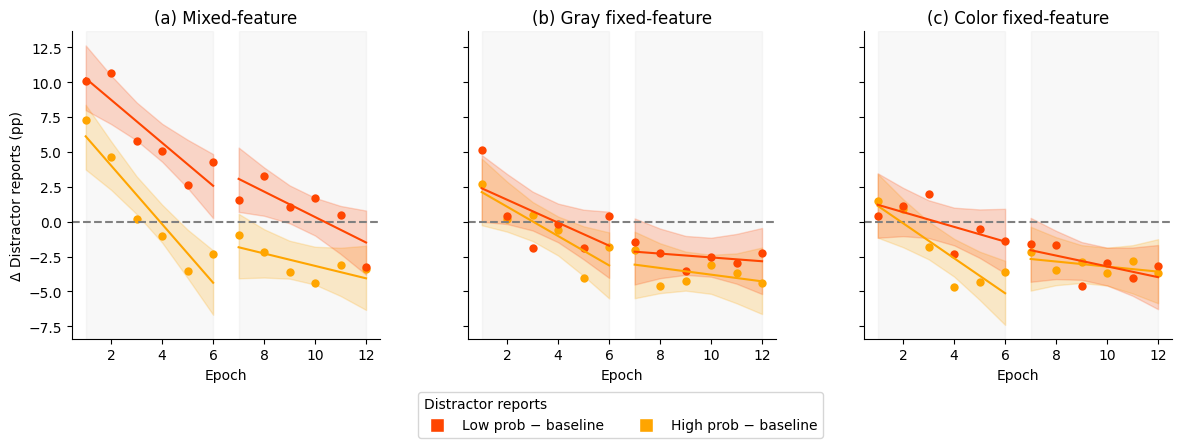

In [9]:
import seaborn as sns
import pandas as pd
import arviz as az
import bambi as bmb
from matplotlib.pylab import plt
from matplotlib.patches import Rectangle
from matplotlib import cycler
from brokenaxes import brokenaxes
from scikits import bootstrap
import numpy as np
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('data/Dataset_TimeCourseDLL.csv', sep=';', decimal=',') 
data['difference'] = pd.to_numeric(data['difference'])
idata = az.from_netcdf('traces/TimeCourseDLL_trace.nc')

model = bmb.Model(
    '''difference ~ 
       task*session*condition*epoch + (1|participant)
    ''',
    data, family='gaussian', categorical = ["session", "condition", "participant"])


palette = {
    "low": "#FF4500",
    "high": "#FFA500"
}

session_to_move = 2 
data_moved = data.copy()
data_moved.loc[data_moved['session'] == session_to_move, 'epoch'] += 6 

g = sns.FacetGrid(data_moved, col='task', hue='session', height=4, col_order = ["color", "gray", "mixed"])
performance_plot = g.map(sns.lineplot, 'epoch', 'difference', 'condition',
                         marker='o', linestyle='', err_style='bars', errorbar=None, palette=palette, markeredgecolor='none')

ax=g.axes

for ax in g.axes[0]:
    ax.set_xlabel("Epoch")
    ax.axvspan(1,6, color='gray', alpha=0.05)
    ax.axvspan(7,12, color='gray', alpha=0.05)


# change/remove labels
plt.figure(1).axes[0].get_yaxis().get_label().set(text='')

plt.figure(1).axes[0].set_title("(c) Color fixed-feature")
plt.figure(1).axes[0].set(position=[0.7, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[0].tick_params(left = True, labelleft = False)
plt.figure(1).axes[0].axhline(y=0, color='gray', linestyle='--')

plt.figure(1).axes[1].set_title("(b) Gray fixed-feature")
plt.figure(1).axes[1].set(position=[0.37, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[1].axhline(y=0, color='gray', linestyle='--')

plt.figure(1).axes[2].set_title("(a) Mixed-feature")
plt.figure(1).axes[2].tick_params(left = True, labelleft = True)
plt.figure(1).axes[2].set(position=[0.04, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[2].text(-0.20, 0.2, 'Δ Distractor reports (pp)', transform=plt.figure(1).axes[2].transAxes, rotation=90.) 
plt.figure(1).axes[2].axhline(y=0, color='gray', linestyle='--')


def plot_slopes_sessions(task, session, condition, ax, color):
    subset = estimates_df.query('task=="%s" and session==%d and condition=="%s"'%(task, session, condition))
    y = subset['estimate']
    offset = ((session==2)*1)*6
    lower, upper = subset['lower_2.5%'], subset['upper_97.5%']
    ax.plot(range(1+offset,7+offset),y, '-', color=color)
    ax.fill_between(range(1+offset,7+offset), lower, upper, alpha=0.2, color=color)
    
    
plot_slopes_sessions('mixed', 1, 'high', ax=plt.figure(1).axes[2], color="#FFA500")
plot_slopes_sessions('mixed', 1, 'low', ax=plt.figure(1).axes[2], color="#FF4500")
plot_slopes_sessions('mixed', 2, 'high', ax=plt.figure(1).axes[2], color="#FFA500")
plot_slopes_sessions('mixed', 2, 'low', ax=plt.figure(1).axes[2], color="#FF4500")

plot_slopes_sessions('color', 1, 'high', ax=plt.figure(1).axes[0], color="#FFA500")
plot_slopes_sessions('color', 1, 'low', ax=plt.figure(1).axes[0], color="#FF4500")
plot_slopes_sessions('color', 2, 'high', ax=plt.figure(1).axes[0], color="#FFA500")
plot_slopes_sessions('color', 2, 'low', ax=plt.figure(1).axes[0], color="#FF4500")

plot_slopes_sessions('gray', 1, 'high', ax=plt.figure(1).axes[1], color="#FFA500")
plot_slopes_sessions('gray', 1, 'low', ax=plt.figure(1).axes[1], color="#FF4500")
plot_slopes_sessions('gray', 2, 'high', ax=plt.figure(1).axes[1], color="#FFA500")
plot_slopes_sessions('gray', 2, 'low', ax=plt.figure(1).axes[1], color="#FF4500")

# Create a custom legend
legend_labels = ['Low prob − baseline', 'High prob − baseline']
custom_legend = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor="#FF4500", markersize=10, label=legend_labels[0]),
                 plt.Line2D([0], [0], marker='s', color='w', markerfacecolor="#FFA500", markersize=10, label=legend_labels[1])]

plt.legend(handles=custom_legend, loc='upper center', bbox_to_anchor=(1.78, -0.15), title='Distractor reports', ncol=3, frameon=True, alignment="left")
_=plt.plot()

### 7) Compute slopes and comparisons

In [10]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import bambi as bmb
from bambi.interpret.helpers import data_grid, select_draws
import warnings
bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

data = pd.read_csv('data/Dataset_TimeCourseDLL.csv', sep=';', decimal='.')

idata = az.from_netcdf('traces/TimeCourseDLL_trace.nc')

model = bmb.Model(
    '''difference ~ 
       task*session*condition*epoch + (1|participant)
    ''',
    data, family='gaussian', categorical = ["session", "condition", "participant"])

# Create data_grid
tasks = ["color", "gray", "mixed"]
sessions = [1, 2]
conditions = ["high", "low"]
participants_mixed = np.arange(1, 19)
participants_gray = np.arange(19, 36)
participants_color = np.arange(36, 54 )

variables = {"epoch": np.arange(1, 7)}

data_dict = {}
idata_dict = {}

for task in tasks:
    if task == "mixed":
        participants = participants_mixed
    elif task == "gray":
        participants = participants_gray
    else:
        participants = participants_color

    conditional = {"participant": participants, "condition": conditions, "session": sessions, "task": np.array([task])}
    key = f"{task}_data"
    data_dict[key] = data_grid(model, conditional, variables)
    idata_dict[key] = model.predict(idata, data=data_dict[key], inplace=False)

        
results_list = []
comparisons_list = []
hdi_S1_high_list = []
hdi_S2_high_list = []
hdi_S1_low_list = []
hdi_S2_low_list = []
hdi_diff_1_list = []
hdi_diff_2_list = []

def calculate_stats(idata_dict, data_dict, task):
    key = f"{task}_data" 
    
    # session 1
    draws_session1_1_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 1}, "difference_mean")
    draws_session1_2_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 2}, "difference_mean")
    draws_session1_3_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 3}, "difference_mean")
    draws_session1_4_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 4}, "difference_mean")
    draws_session1_5_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 5}, "difference_mean")
    draws_session1_6_high = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "high", "epoch": 6}, "difference_mean")
    
    draws_session1_1_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 1}, "difference_mean")
    draws_session1_2_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 2}, "difference_mean")
    draws_session1_3_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 3}, "difference_mean")
    draws_session1_4_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 4}, "difference_mean")
    draws_session1_5_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 5}, "difference_mean")
    draws_session1_6_low = select_draws(idata_dict[key], data_dict[key], {"session": 1, "condition": "low", "epoch": 6}, "difference_mean")

    # session 2
    draws_session2_1_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 1}, "difference_mean")
    draws_session2_2_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 2}, "difference_mean")
    draws_session2_3_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 3}, "difference_mean")
    draws_session2_4_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 4}, "difference_mean")
    draws_session2_5_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 5}, "difference_mean")
    draws_session2_6_high = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "high", "epoch": 6}, "difference_mean")

    draws_session2_1_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 1}, "difference_mean")
    draws_session2_2_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 2}, "difference_mean")
    draws_session2_3_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 3}, "difference_mean")
    draws_session2_4_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 4}, "difference_mean")
    draws_session2_5_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 5}, "difference_mean")
    draws_session2_6_low = select_draws(idata_dict[key], data_dict[key], {"session": 2, "condition": "low", "epoch": 6}, "difference_mean")        

    # slopes
    diff_session1_epoch_21_high = (draws_session1_2_high - draws_session1_1_high)    
    diff_session1_epoch_32_high = (draws_session1_3_high - draws_session1_2_high)
    diff_session1_epoch_43_high = (draws_session1_4_high - draws_session1_3_high)
    diff_session1_epoch_54_high = (draws_session1_5_high - draws_session1_4_high)
    diff_session1_epoch_65_high = (draws_session1_6_high - draws_session1_5_high)
    
    diff_session1_epoch_21_low = (draws_session1_2_low - draws_session1_1_low)    
    diff_session1_epoch_32_low = (draws_session1_3_low - draws_session1_2_low)
    diff_session1_epoch_43_low = (draws_session1_4_low - draws_session1_3_low)
    diff_session1_epoch_54_low = (draws_session1_5_low - draws_session1_4_low)
    diff_session1_epoch_65_low = (draws_session1_6_low - draws_session1_5_low)

    diff_session2_epoch_21_high = (draws_session2_2_high - draws_session2_1_high)
    diff_session2_epoch_32_high = (draws_session2_3_high - draws_session2_2_high)
    diff_session2_epoch_43_high = (draws_session2_4_high - draws_session2_3_high)
    diff_session2_epoch_54_high = (draws_session2_5_high - draws_session2_4_high)
    diff_session2_epoch_65_high = (draws_session2_6_high - draws_session2_5_high)
    
    diff_session2_epoch_21_low = (draws_session2_2_low - draws_session2_1_low)
    diff_session2_epoch_32_low = (draws_session2_3_low - draws_session2_2_low)
    diff_session2_epoch_43_low = (draws_session2_4_low - draws_session2_3_low)
    diff_session2_epoch_54_low = (draws_session2_5_low - draws_session2_4_low)
    diff_session2_epoch_65_low = (draws_session2_6_low - draws_session2_5_low)


    slopes_session1 =xr.concat([xr.concat([diff_session1_epoch_21_high,
               diff_session1_epoch_32_high,
               diff_session1_epoch_43_high,
               diff_session1_epoch_54_high,
               diff_session1_epoch_65_high],
              'Epoche')\
        .mean(dim='Epoche'),
        xr.concat([diff_session1_epoch_21_low,
               diff_session1_epoch_32_low,
               diff_session1_epoch_43_low,
               diff_session1_epoch_54_low,
               diff_session1_epoch_65_low],
              'Epoche')\
        .mean(dim='Epoche')],
        dim='Condition'
    ).rename('Slopes')
    
    slopes_session2 = xr.concat([xr.concat([diff_session2_epoch_21_high,
               diff_session2_epoch_32_high,
               diff_session2_epoch_43_high,
               diff_session2_epoch_54_high,
               diff_session2_epoch_65_high],
              'Epoche')\
        .mean(dim='Epoche'),
         xr.concat([diff_session2_epoch_21_low,
               diff_session2_epoch_32_low,
               diff_session2_epoch_43_low,
               diff_session2_epoch_54_low,
               diff_session2_epoch_65_low],
              'Epoche')\
        .mean(dim='Epoche')],
        dim='Condition'
    ).rename('Slopes')

    
    slopes_diff_1 = (slopes_session1.sel(Condition=1) - slopes_session1.sel(Condition=0)).mean(dim='difference_obs').values
    comparisons_list.append({"session": 1, "condition": "Δ (low, high)", "task": task, "slope": np.mean(slopes_diff_1)})
    hdi_diff_1 = az.hdi((slopes_session1.sel(Condition=1) - slopes_session1.sel(Condition=0)).mean(dim='difference_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_diff_df_1 = hdi_diff_1.to_dataframe(dim_order=None)
    hdi_diff_1_list.append(hdi_diff_df_1)
    
    slopes_diff_2 = (slopes_session2.sel(Condition=1) - slopes_session2.sel(Condition=0)).mean(dim='difference_obs').values
    comparisons_list.append({"session": 2, "condition": "Δ (low, high)", "task": task, "slope": np.mean(slopes_diff_2)})
    hdi_diff_2 = az.hdi((slopes_session2.sel(Condition=1) - slopes_session2.sel(Condition=0)).mean(dim='difference_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_diff_df_2 = hdi_diff_2.to_dataframe(dim_order=None)
    hdi_diff_2_list.append(hdi_diff_df_2)
    
for task in tasks:
    calculate_stats(idata_dict, data_dict, task)


within_comparisons_df = pd.DataFrame(comparisons_list)

Session1_diff_indices = within_comparisons_df[within_comparisons_df['session'] == 1].index
Session2_diff_indices = within_comparisons_df[within_comparisons_df['session'] == 2].index


def extract_hdi_values(hdi_df):
    lower_value = hdi_df.loc['lower', 'Slopes']
    higher_value = hdi_df.loc['higher', 'Slopes']
    return lower_value, higher_value

for S1_index_diff, hdi_df in zip(Session1_diff_indices, hdi_diff_1_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    within_comparisons_df.at[S1_index_diff, 'lower_2.5%'] = lower_col
    within_comparisons_df.at[S1_index_diff, 'upper_97.5%'] = higher_col

for S2_index_diff, hdi_df in zip(Session2_diff_indices, hdi_diff_2_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    within_comparisons_df.at[S2_index_diff, 'lower_2.5%'] = lower_col
    within_comparisons_df.at[S2_index_diff, 'upper_97.5%'] = higher_col
    

within_comparisons_df = within_comparisons_df.round({'slope': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})
display(within_comparisons_df)

,session,condition,task,slope,lower_2.5%,upper_97.5%
0,1,"Δ (low, high)",color,0.73,-0.35,1.79
1,2,"Δ (low, high)",color,-0.21,-1.29,0.85
2,1,"Δ (low, high)",gray,0.23,-0.89,1.35
3,2,"Δ (low, high)",gray,0.10,-1.00,1.22
4,1,"Δ (low, high)",mixed,0.56,-0.51,1.65
5,2,"Δ (low, high)",mixed,-0.47,-1.54,0.61
